# 05b Cell search for TC outcome

### Contents:
1. Set up and preparation for cell search  
1.1. Fit the top ensemble  
1.2. Find important features  
1.3. Determine most significant q values
2. Cell search  
3. Examining cell search results  
3.1. Coverage of quantile-based top subgroups by cell union  
3.2. Significance of selected cells  
3.3. Significance of selected cells w.r.t. TC outcome  
3.4. Similarity of selected cells
4. Results on test set  
4.1. Significance of selected cells  
4.2. Significance of selected cells w.r.t. TC outcome  
4.3. Significance of selected cells w.r.t. TC outcome, on TC-based split  
4.4. Significance of selected cells w.r.t. TC outcome, on all data

## 1. Set up and preparation for cell search

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import own methods
from methods.data_processing import prepare_df, separate_vars
from methods.causal_functions import get_Neyman_ATE, get_Neyman_var
from methods.cate_estimator_wrappers import combine_estimator_versions
from methods.cate_estimator_validation import make_top_ensemble, get_top_subgroup_stability
from methods.cell_search import (get_feature_importance_scores, compare_q_values,
                                 CellSearch, get_cell_search_results,
                                 aggregate_cell_search_results, 
                                 get_coverage_results, get_cell_overlap_results, 
                                 get_cell_significance_results, get_RR_results)

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
features = ["male", "white", "US", "PUB_PRIOR_HISTORY", 'elderly_65_adj',
            "HYPGRP", "DBTGRP", "CHLGRP", "ASPFDA", "ASCGRP", 'obese',
            "PSTRDS", "PNSAIDS", "PNAPRXN", "smoker", "drinker"]
n_splits = 4
q_values = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
outcome_name = "cfd_cardio"
dir_neg = False
FILE_PATH = f"data_files/{outcome_name}/"

If notebook has already been run before, load cache of intermediate results using this cell.

In [3]:
# Load intermediate results of notebook
top_ensemble = joblib.load(FILE_PATH + f"{outcome_name}_top_ensemble")
top_estimator_names = joblib.load(FILE_PATH + f"{outcome_name}_top_estimator_names")
top_features = joblib.load(FILE_PATH + f"{outcome_name}_top_features")
search_results_df = joblib.load(FILE_PATH + f"{outcome_name}_cell_search_results")

### 1.1. Fit the top ensemble

In [3]:
# Fit the top ensemble
fitted_libraries = joblib.load(FILE_PATH + f"{outcome_name}_fitted_libraries")
top_estimator_names = joblib.load(FILE_PATH + f"{outcome_name}_top_estimator_names")
top_ensemble = make_top_ensemble(fitted_libraries, top_estimator_names)

In [4]:
print("Top ensemble estimators are:")
for idx, estimator_name in enumerate(top_estimator_names):
    print(idx + 1, estimator_name)

Top ensemble estimators are:
1 s_rf
2 t_lasso
3 t_rf
4 x_xgb
5 t_logistic


In [5]:
# Dump the top ensemble
joblib.dump(top_ensemble, FILE_PATH + f"{outcome_name}_top_ensemble")

['data_files/cfd_cardio/cfd_cardio_top_ensemble']

### 1.2. Find significant quantile

In [4]:
compare_q_values(top_ensemble, [0.1, 0.2, 0.3, 0.4, 0.5], dir_neg=dir_neg).round(2)

,t-stat mean,t-stat std,overlap mean
0.1,1.28,0.22,0.77
0.2,1.03,0.12,0.75
0.3,0.85,0.12,0.77
0.4,0.71,0.09,0.79
0.5,0.57,0.13,0.82


In [5]:
# Run this cell to generate latex code for table
#print(compare_q_values(top_ensemble, [0.1, 0.2, 0.3, 0.4, 0.5]).round(2).to_latex())

The 0.1, 0.2 q value gives by far the best $t$-statistic score, so we shall find important features and then cells that approximate it.  
We further check the stability of the quantile-based top subgroup of the ensemble w.r.t q = 0.1 and q = 0.2, by computing what  
percentage of its members are contained in the quantile-based top subgroup for other values of q, when the two subgroups are  
obtained from ensembles trained on different data splits.

In [6]:
q0 = 0.2
q_values_v2 = [0.2, 0.3, 0.4, 0.5]
get_top_subgroup_stability(top_ensemble, q0, q_values_v2, dir_neg).round(2)

,mean coverage,coverage std
0.2,0.75,0.07
0.3,0.88,0.07
0.4,0.94,0.05
0.5,0.97,0.04


In [8]:
q0 = 0.1
get_top_subgroup_stability(top_ensemble, q0, [0.1,0.2,0.3,0.4,0.5], dir_neg).round(2)

,mean coverage,coverage std
0.1,0.77,0.07
0.2,0.93,0.06
0.3,0.97,0.05
0.4,0.98,0.04
0.5,0.99,0.03


### 1.3. Find important features

First we generate two different kinds of feature importance scores (refer to paper for details).  
We genereate these scores for each q in {0.1,0.2,0.3,0.4,0.5}.

In [9]:
mean_difference_df = get_feature_importance_scores(top_ensemble, "mean_difference", 
                                                   q_values, features, dir_neg).round(2)
mean_difference_df

,0.5,0.4,0.3,0.2,0.1,max,mean
male,0.14,0.16,0.18,0.20,0.16,0.20,0.17
white,0.12,0.11,0.10,0.09,0.07,0.12,0.10
US,0.11,0.10,0.10,0.10,0.07,0.11,0.10
PUB_PRIOR_HISTORY,-0.02,-0.02,-0.01,-0.01,-0.01,0.02,0.02
elderly_65_adj,0.10,0.11,0.12,0.13,0.14,0.14,0.12
HYPGRP,0.00,0.01,0.02,0.02,0.04,0.04,0.02
DBTGRP,0.00,0.00,0.00,0.01,0.01,0.01,0.01
CHLGRP,0.03,0.04,0.04,0.04,0.04,0.04,0.04
ASPFDA,0.03,0.04,0.05,0.08,0.14,0.14,0.07
ASCGRP,0.04,0.05,0.07,0.10,0.16,0.16,0.08


In [10]:
log_coef_df = get_feature_importance_scores(top_ensemble, "log_coef", 
                                            q_values, features, dir_neg)
log_coef_df.round(2)

,0.5,0.4,0.3,0.2,0.1,max,mean
male,0.12,0.12,0.12,0.13,0.13,0.13,0.12
white,0.05,0.05,0.05,0.04,0.04,0.05,0.04
US,0.03,0.03,0.03,0.04,0.04,0.04,0.03
PUB_PRIOR_HISTORY,-0.07,-0.07,-0.07,-0.06,-0.07,0.07,0.07
elderly_65_adj,0.08,0.08,0.09,0.10,0.11,0.11,0.09
HYPGRP,-0.02,-0.02,-0.01,-0.01,0.00,0.02,0.01
DBTGRP,-0.02,-0.02,-0.03,-0.03,-0.03,0.03,0.03
CHLGRP,0.04,0.04,0.03,0.03,0.02,0.04,0.03
ASPFDA,0.10,0.12,0.16,0.23,0.28,0.28,0.18
ASCGRP,0.17,0.16,0.14,0.12,0.09,0.17,0.14


We rank the features by taking the mean over the scores for q=0.1 and q=0.2.

In [13]:
qs = [0.1, 0.2]
df2 = pd.DataFrame(log_coef_df[qs].mean(1), columns=["mean"])
df1 = pd.DataFrame(mean_difference_df[qs].mean(1), columns=["mean"])

q_pick = "mean"

df2[q_pick] = np.abs(df2[q_pick])
df2 = df2.sort_values(q_pick, ascending=False)


df1[q_pick] = np.abs(df1[q_pick])
df1 = df1.reindex(df2.index)

ticks = df1.index.to_list()

In [12]:
mean_difference_top = df1.sort_values(q_pick, ascending = False)[:8].iloc[:, :-2]
log_coef_top = df2.sort_values(q_pick, ascending = False)[:8].iloc[:, :-2]

top_features = np.unique(np.hstack((mean_difference_top.index, log_coef_top.index)))
print("Top features are:", top_features)
print("Num top features:", len(top_features))
joblib.dump(top_features, FILE_PATH + f"{outcome_name}_top_features")

Top features are: ['ASCGRP' 'ASPFDA' 'CHLGRP' 'PUB_PRIOR_HISTORY' 'US' 'elderly_65_adj'
 'male' 'obese' 'smoker' 'white']
Num top features: 10


['data_files/cfd_cardio/cfd_cardio_top_features']

Let's now plot the scores.

In [15]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"

In [16]:
# Change the labels for the features to make the plot more readable
for i, tick in enumerate(ticks):
    if tick == "PUB_PRIOR_HISTORY":
        ticks[i] = "PPH"
    if tick == "smoker":
        ticks[i] = "SMOKE"
    if tick == "drinker":
        ticks[i] = "DRINK"
    if tick == "overweight":
        ticks[i] = "OVERWT"
    if tick == "male":
        ticks[i] = "MALE"
    if tick == "white":
        ticks[i] = "WHITE"
    if tick == 'elderly_65_adj':
        ticks[i] = "ELDERLY"
    if tick == 'obese':
        ticks[i] = "OBESE"
        
imp_type =  ["Logistic"]*len(df2)
imp_type += ["Difference"]*len(df1)

In [17]:
d = {'values': np.hstack((df2[q_pick].values/sum(df2[q_pick].values), df1[q_pick].values/sum(df1[q_pick].values))),
     "feature" : ticks*2,
    'type': imp_type}

In [32]:
joblib.dump(d, f"data_files/{outcome_name}/{outcome_name}_feat_imp")

['data_files/cfd_cardio/cfd_cardio_feat_imp']

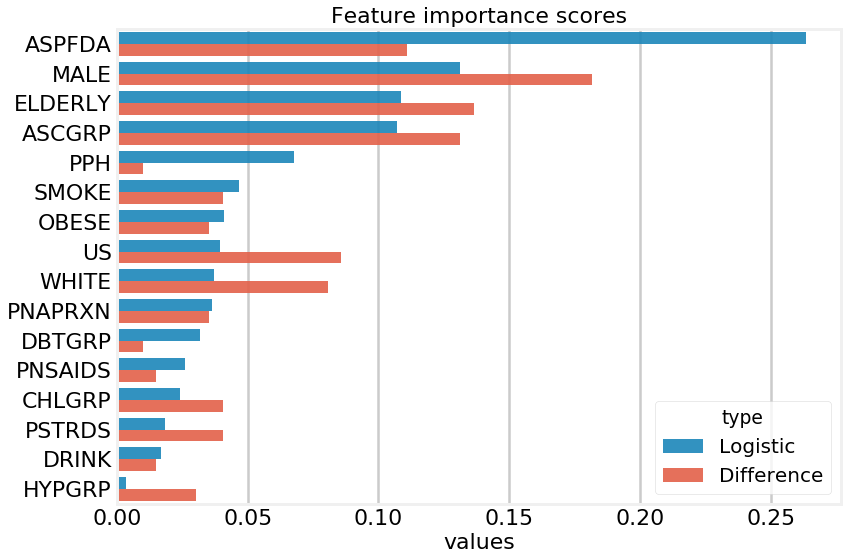

In [18]:
savfig = False
temp_df = pd.DataFrame(d)
fig, ax = plt.subplots(figsize=[12, 8])
sns.barplot(y='feature', x='values', hue='type', data=temp_df,  orient='h', ax=ax, alpha=0.9)
ax.set_ylabel('')
plt.title("Feature importance scores")
plt.tight_layout()
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_feat_imp.pdf")
plt.show()

## 2. Cell search

A description of the cell search algorithm can be found in the paper.

In this section, we perform multiple runs of cell search, by varying the training fold used to train  
the estimator. Furthermore, in cell search, there is an option to randomize the algorithm by choosing  
randomly from among a list of top cells. In the multiple runs, we also vary the random seed used to do  
this.

In [22]:
# Options for cell search
q_values = [0.1, 0.2]
n_cells = 3
max_features = 3
n_reps = 5
penalty = 1
tol = 0.05
min_support = 0.001
dir_neg = False
trainval_df = pd.DataFrame(top_ensemble.X, columns = features)

In [6]:
# Run cell search
search_results_df = get_cell_search_results(top_ensemble, features, top_features, 
                            q_values, n_cells, max_features, n_reps, penalty, 
                            tol, min_support, dir_neg)

100%|██████████| 12/12 [06:29<00:00, 32.43s/it]


In [7]:
# Dump cell search results
joblib.dump(search_results_df, FILE_PATH + f"{outcome_name}_cell_search_results")

['data_files/cfd_cardio/cfd_cardio_cell_search_results']

In [23]:
aggregated_results_df = aggregate_cell_search_results(search_results_df, trainval_df, 
                                                      collapse_cells = True).round(2)
aggregated_results_df[:20]

,q=0.1,q=0.2,num runs,total frequency,max frequency
cells,,,,,
(ASPFDA_1),49.00,30.00,60,0.66,0.82
"(male_1, elderly_65_adj_1)",42.30,34.00,60,0.64,0.71
(ASCGRP_1),19.29,32.36,60,0.43,0.54
(male_1),0.00,37.04,60,0.31,0.62
"(elderly_65_adj_1, smoker_1)",13.32,16.19,60,0.25,0.27
"(male_1, elderly_65_adj_1, US_1)",18.00,0.00,60,0.15,0.30
"(male_1, US_1)",0.00,15.81,60,0.13,0.26
"(elderly_65_adj_1, obese_1)",0.00,12.38,60,0.10,0.21
"(male_1, elderly_65_adj_1, white_1)",12.00,0.00,60,0.10,0.20


Here, we have aggregated the cell search results, with the `collapse_cells` flag set to `True`.  
This means that to the count of each cell, we also add the count of sub-cells that occur, weighted  
by their size (in terms of number of samples) relative to that of the super-cell.

In [20]:
# aggregated_results_df = aggregate_cell_search_results(search_results_df, trainval_df, 
#                                                       collapse_cells = False).round(2)
# aggregated_results_df

We now simplify this table for display in the paper. We rank the cells according to their "mean",  
i.e. the mean of the frequency with which they were selected for each q value.

In [24]:
agg_results = aggregated_results_df[["q=%.1f"%q for q in q_values] + ["total frequency"]] \
                            .rename(columns={"total frequency":"mean"})[:20]
for q in q_values:
    agg_results["q=%.1f"%q] /= aggregated_results_df["num runs"]

for column in agg_results.keys():
    agg_results[column] *= 100
agg_results = agg_results.round(0).astype(int)
agg_results

,q=0.1,q=0.2,mean
cells,,,
(ASPFDA_1),82,50,66
"(male_1, elderly_65_adj_1)",70,57,64
(ASCGRP_1),32,54,43
(male_1),0,62,31
"(elderly_65_adj_1, smoker_1)",22,27,25
"(male_1, elderly_65_adj_1, US_1)",30,0,15
"(male_1, US_1)",0,26,13
"(elderly_65_adj_1, obese_1)",0,21,10
"(male_1, elderly_65_adj_1, white_1)",20,0,10


In [27]:
top_cells = list(agg_results.index[:3])

We manually format this table for the paper.

In [30]:
#agg_table = agg_results.to_latex()

In [25]:
# format_table = ''
# j = 0
# while(j<len(agg_table)):
#     s = agg_table[j]
#     if s == '(':
#         format_table += "\{"
#         j+=1
#     elif s== ')':
#         format_table += "\}"
#         j+=1
#     elif agg_table[j:j+5] == 'white':
#         format_table += "WHITE"
#         j+=5
#     elif agg_table[j:j+6] == 'smoker':
#         format_table += "SMOKE"
#         j+=6
#     elif agg_table[j:j+16] == "elderly\_65\_adj":
#         format_table += "ELDERLY"
#         j+=16
#     elif agg_table[j:j+19] =='PUB\_PRIOR\_HISTORY':
#         format_table += "PPH"
#         j+=19
#     elif agg_table[j:j+7] =='drinker':
#         format_table += "DRINK"
#         j+=7
#     elif agg_table[j:j+10] =='overweight':
#         format_table += "OVERWEIGHT"
#         j+=10
#     elif agg_table[j:j+5] =='obese':
#         format_table += "OBESE"
#         j+=5
#     elif agg_table[j:j+4] =='male':
#         format_table += "MALE"
#         j+=4
#     elif agg_table[j:j+3] =='\_1':
#         format_table += "=1"
#         j+=3
#     elif agg_table[j:j+3] =='\_0':
#         format_table += "=0"
#         j+=3
#     else:
#         format_table += s
#         j+=1
# print(format_table)

## 3. Examining cell search results

In [126]:
print("The cells selected are: ")
for idx, cell in enumerate(top_cells):
    print(f"{idx+1}.", cell)

The cells selected are: 
1. frozenset({'ASPFDA_1'})
2. frozenset({'male_1', 'elderly_65_adj_1'})
3. frozenset({'ASCGRP_1'})


### 3.1. Coverage of quantile-based top subgroups by cell union

This first table shows the coverage statistics of the cells selected with respect to various q values.

In [28]:
coverage_results_df = get_coverage_results(top_cells, trainval_df, top_ensemble, 
                                           [0.1, 0.2, 0.3, 0.4, 0.5], dir_neg)
coverage_results_df.round(2)

,TP mean,FP mean,FN mean,TP std,FN std
0.1,513.25,202.75,132.08,48.72,55.21
0.2,640.08,75.92,655.00,39.75,45.51
0.3,678.50,37.50,1256.17,30.65,36.09
0.4,691.92,24.08,1878.08,27.63,36.33
0.5,699.42,16.58,2534.00,23.08,41.39


### 3.2. Significance of selected cells

The next two tables display the CATE, $t$-statistic and relative risk of the selected cells as well as their union.

In [29]:
sig_cate = get_cell_significance_results(top_cells, top_ensemble.y, 
                                         top_ensemble.t, trainval_df, top_ensemble)
sig_cate.round(3)

,size,num_evts,CATE,CATE_std,t-stat (overall),t-stat (val) mean,t-stat (val) std
ASPFDA==1,263,13,0.062,0.025,2.283,1.089,0.202
male==1 & elderly_65_adj==1,383,12,0.040,0.017,2.087,0.847,0.239
ASCGRP==1,376,15,0.044,0.020,2.052,1.037,0.229
union,716,24,0.042,0.013,3.088,1.548,0.129


In [30]:
get_RR_results(top_cells, top_ensemble.y, top_ensemble.t, trainval_df).round(2)

,size,relative risk,CI lower endpoint,CI upper endpoint
ASPFDA==1,263,4.76,1.08,21.05
male==1 & elderly_65_adj==1,383,4.77,1.06,21.49
ASCGRP==1,376,3.60,1.03,12.54
union,716,4.57,1.58,13.24
entire population,6460,2.35,1.26,4.37


### 3.3. Significance of selected cells w.r.t. GI

In [32]:
cross_outcome = "cfd_cardio" if outcome_name == "GI" else "GI"
BASE_DIR = "/home/ubuntu/vioxx_vigor/"
DATA_PATH = BASE_DIR + "data/01_transformed/20jul2020/"
cross_train_df = prepare_df(DATA_PATH + f"{outcome_name}/trainval_data.csv", 
                            features, cross_outcome)
_, _, GI_df = separate_vars(cross_train_df, cross_outcome)

In [33]:
cross_cate_train = get_cell_significance_results(top_cells,
                        GI_df, top_ensemble.t, trainval_df, top_ensemble).round(3)
cross_cate_train

,size,num_evts,CATE,CATE_std,t-stat (overall),t-stat (val) mean,t-stat (val) std
ASPFDA==1,263,6,-0.034,0.019,-0.884,0.051,0.388
male==1 & elderly_65_adj==1,383,12,-0.043,0.018,-1.511,-0.577,0.250
ASCGRP==1,376,8,-0.034,0.015,-1.141,-0.178,0.337
union,716,20,-0.042,0.013,-2.084,-0.870,0.255


In [34]:
get_RR_results(top_cells, GI_df, top_ensemble.t, trainval_df).round(2)

,size,relative risk,CI lower endpoint,CI upper endpoint
ASPFDA==1,263,0.17,0.02,1.46
male==1 & elderly_65_adj==1,383,0.19,0.04,0.86
ASCGRP==1,376,0.13,0.02,1.03
union,716,0.16,0.05,0.55
entire population,6460,0.44,0.31,0.62


### 3.4. Similarity of selected cells

The following two heat maps show how similar the selected cells are to each other, in terms of intersection size and cosine similarity.

In [127]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"


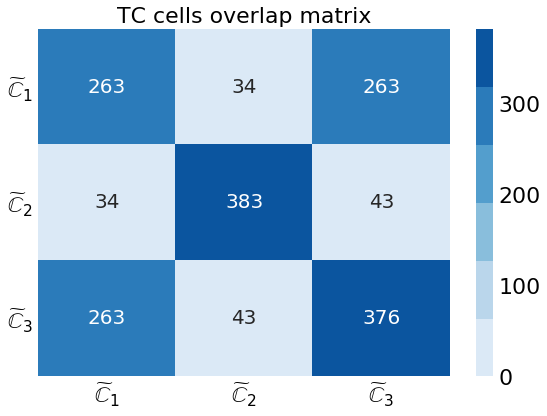

In [62]:
savfig = False
intersection_mat = get_cell_overlap_results(top_cells, trainval_df, "intersection_size")
joblib.dump(intersection_mat, FILE_PATH + f"{outcome_name}_cell_overlap_mat")
c = intersection_mat.shape[0]
plt.figure(figsize=[8, 6])
sns.heatmap(intersection_mat, annot = True, fmt = "d", 
            cmap = sns.color_palette("Blues"), annot_kws={'size':20},
            vmin = 0, vmax = intersection_mat.values.max())
cell_ticks = [r'$\widetilde{\mathbb{C}}_{%d}$'%(j+1) for j in range(c)]
plt.xticks(np.arange(c)+0.5, cell_ticks)
plt.yticks(np.arange(c)+0.5, cell_ticks, rotation=0)
plt.title("TC cells overlap matrix")
plt.tight_layout()

if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_cell_heatmap.pdf")
plt.show()

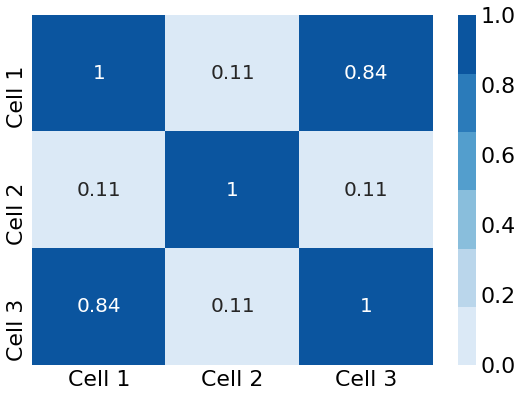

In [36]:
cosine_sim_mat = get_cell_overlap_results(top_cells, trainval_df, "cosine_sim")
plt.figure()
sns.heatmap(cosine_sim_mat, annot = True, cmap = sns.color_palette("Blues"),annot_kws={'size':20}, vmin = 0, vmax = 1)
plt.show()

# 4. Results on test Set 

### 4.1. Significance of selected cells  

In [40]:
BASE_DIR = "/home/ubuntu/vioxx_vigor/"
DATA_PATH = BASE_DIR + "data/01_transformed/20jul2020/"
test_df = prepare_df(DATA_PATH + f"{outcome_name}/test_data.csv", 
                     features, outcome_name)
trainval_df = prepare_df(DATA_PATH + f"{outcome_name}/trainval_data.csv", 
                         features, outcome_name)

In [41]:
print("Train")
sig_cate.round(3)

Train


,size,num_evts,CATE,CATE_std,t-stat (overall),t-stat (val) mean,t-stat (val) std
ASPFDA==1,263,13,0.062,0.025,2.283,1.089,0.202
male==1 & elderly_65_adj==1,383,12,0.040,0.017,2.087,0.847,0.239
ASCGRP==1,376,15,0.044,0.020,2.052,1.037,0.229
union,716,24,0.042,0.013,3.088,1.548,0.129


In [42]:
print("Test")
test_cate = get_cell_significance_results(top_cells, test_df[outcome_name], 
                                          test_df["TREATED"], test_df[features], 
                                          on_trainval = False)
test_cate.round(3)

Test


,size,num_evts,CATE,CATE_std,t-stat (overall)
ASPFDA==1,58,5,0.103,0.074,1.384
male==1 & elderly_65_adj==1,111,0,0.000,0.000,-1.155
ASCGRP==1,78,6,0.047,0.060,0.737
union,175,6,0.024,0.028,0.765


Let's combine both tables together.

In [43]:
cate_join = sig_cate.join(test_cate,
                        how='outer', lsuffix="_train", rsuffix="_test")
cate_join[['num_evts_train', 'size_train', 'num_evts_test', 'size_test', 
           'CATE_train', 'CATE_std_train', 'CATE_test', 'CATE_std_test', 
           't-stat (overall)_train', 't-stat (overall)_test', 
           "t-stat (val) mean", "t-stat (val) std"]].round(3)

,num_evts_train,size_train,num_evts_test,size_test,CATE_train,CATE_std_train,CATE_test,CATE_std_test,t-stat (overall)_train,t-stat (overall)_test,t-stat (val) mean,t-stat (val) std
ASPFDA==1,13,263,5,58,0.062,0.025,0.103,0.074,2.283,1.384,1.089,0.202
male==1 & elderly_65_adj==1,12,383,0,111,0.040,0.017,0.000,0.000,2.087,-1.155,0.847,0.239
ASCGRP==1,15,376,6,78,0.044,0.020,0.047,0.060,2.052,0.737,1.037,0.229
union,24,716,6,175,0.042,0.013,0.024,0.028,3.088,0.765,1.548,0.129


For reference, we generate the ATE over train and test sets.

In [45]:
ATE_df = pd.DataFrame(columns = ["size", "num events", "ATE", "ATE std"])
for name, df in zip(["train", "test"], [trainval_df, test_df]):
    size = df.shape[0]
    num_events = df[outcome_name].sum()
    ATE = get_Neyman_ATE(df[outcome_name], df["TREATED"])
    ATE_std = np.sqrt(get_Neyman_var(df[outcome_name], df["TREATED"]))
    ATE_df = ATE_df.append(pd.Series({"size" : size, "num events" : num_events, 
                                      "ATE" : ATE, "ATE std" : ATE_std}, 
                                     name = name))

In [46]:
ATE_df.round(3)

,size,num events,ATE,ATE std
train,6460.0,47.0,0.006,0.002
test,1616.0,12.0,0.005,0.004


### 4.2. Significance of selected cells w.r.t. GI outcome  

In [47]:
cross_outcome = "cfd_cardio" if outcome_name == "GI" else "GI"
BASE_DIR = "/home/ubuntu/vioxx_vigor/"
DATA_PATH = BASE_DIR + "data/01_transformed/20jul2020/"
cross_test_df = prepare_df(DATA_PATH + f"{outcome_name}/test_data.csv", 
                           features, cross_outcome)

In [48]:
print(f"train {cross_outcome} on {outcome_name} split")
cross_cate_train

train GI on cfd_cardio split


,size,num_evts,CATE,CATE_std,t-stat (overall),t-stat (val) mean,t-stat (val) std
ASPFDA==1,263,6,-0.034,0.019,-0.884,0.051,0.388
male==1 & elderly_65_adj==1,383,12,-0.043,0.018,-1.511,-0.577,0.250
ASCGRP==1,376,8,-0.034,0.015,-1.141,-0.178,0.337
union,716,20,-0.042,0.013,-2.084,-0.870,0.255


In [49]:
print(f"test {cross_outcome} on {outcome_name} split")
cross_test_cate = get_cell_significance_results(top_cells, 
                cross_test_df[cross_outcome], cross_test_df["TREATED"], 
                cross_test_df[features], on_trainval = False)
cross_test_cate.round(3)

test GI on cfd_cardio split


,size,num_evts,CATE,CATE_std,t-stat (overall)
ASPFDA==1,58,0,0.000,0.000,1.694
male==1 & elderly_65_adj==1,111,5,-0.052,0.039,-1.067
ASCGRP==1,78,0,0.000,0.000,1.694
union,175,5,-0.033,0.025,-0.898


Let's combine both tables together.

In [50]:
cross_join = cross_cate_train.join(cross_test_cate,
                        how='outer', lsuffix="_train", rsuffix="_test")

cross_join[['num_evts_train', 'size_train', 'num_evts_test', 'size_test', 
            'CATE_train', 'CATE_std_train', 'CATE_test', 'CATE_std_test', 
            't-stat (overall)_train', 't-stat (overall)_test', "t-stat (val) mean", 
            "t-stat (val) std"]].round(3)

,num_evts_train,size_train,num_evts_test,size_test,CATE_train,CATE_std_train,CATE_test,CATE_std_test,t-stat (overall)_train,t-stat (overall)_test,t-stat (val) mean,t-stat (val) std
ASPFDA==1,6,263,0,58,-0.034,0.019,0.000,0.000,-0.884,1.694,0.051,0.388
male==1 & elderly_65_adj==1,12,383,5,111,-0.043,0.018,-0.052,0.039,-1.511,-1.067,-0.577,0.250
ASCGRP==1,8,376,0,78,-0.034,0.015,0.000,0.000,-1.141,1.694,-0.178,0.337
union,20,716,5,175,-0.042,0.013,-0.033,0.025,-2.084,-0.898,-0.870,0.255


For reference, we generate the ATE over train and test sets.

In [51]:
ATE_df = pd.DataFrame(columns = ["size", "num events", "ATE", "ATE std"])
for name, df in zip(["train", "test"], [cross_train_df, cross_test_df]):
    size = df.shape[0]
    num_events = df[cross_outcome].sum()
    ATE = get_Neyman_ATE(df[cross_outcome], df["TREATED"])
    ATE_std = np.sqrt(get_Neyman_var(df[cross_outcome], df["TREATED"]))
    ATE_df = ATE_df.append(pd.Series({"size" : size, "num events" : num_events, 
                                      "ATE" : ATE, "ATE std" : ATE_std}, 
                                     name = name))

In [52]:
ATE_df.round(3)

,size,num events,ATE,ATE std
train,6460.0,141.0,-0.017,0.004
test,1616.0,36.0,-0.012,0.007


### 4.3. Significance of selected cells w.r.t. GI outcome, on GI-based split

In [53]:
cross_outcome = "cfd_cardio" if outcome_name == "GI" else "GI"
BASE_DIR = "/home/ubuntu/vioxx_vigor/"
DATA_PATH = BASE_DIR + "data/01_transformed/20jul2020/"
new_cross_test_df = prepare_df(DATA_PATH + f"{cross_outcome}/test_data.csv", 
                               features, cross_outcome)
new_cross_train_df = prepare_df(DATA_PATH + f"{cross_outcome}/trainval_data.csv", 
                                features, cross_outcome)

In [54]:
print(f"train {cross_outcome} on {cross_outcome} split")
new_cross_train_cate = get_cell_significance_results(top_cells, 
                        new_cross_train_df[cross_outcome], new_cross_train_df["TREATED"], 
                            new_cross_train_df[features], on_trainval = False)
new_cross_train_cate.round(3)

train GI on GI split


,size,num_evts,CATE,CATE_std,t-stat (overall)
ASPFDA==1,260,5,-0.042,0.019,-1.431
male==1 & elderly_65_adj==1,409,13,-0.044,0.017,-1.689
ASCGRP==1,365,7,-0.042,0.016,-1.696
union,728,20,-0.046,0.012,-2.608


In [55]:
print(f"test {cross_outcome} on {cross_outcome} split")
new_cross_test_cate = get_cell_significance_results(top_cells, 
                                new_cross_test_df[cross_outcome], 
                    new_cross_test_df["TREATED"], new_cross_test_df[features], 
                                                    on_trainval = False)
new_cross_test_cate.round(3)

test GI on GI split


,size,num_evts,CATE,CATE_std,t-stat (overall)
ASPFDA==1,61,1,0.036,0.036,1.474
male==1 & elderly_65_adj==1,85,4,-0.053,0.048,-0.799
ASCGRP==1,89,1,0.025,0.025,1.660
union,163,5,-0.011,0.027,0.200


Let's combine both tables together.

In [56]:
new_cross_join = new_cross_train_cate.join(new_cross_test_cate,
                        how='outer', lsuffix="_train", rsuffix="_test")

print(f"Cross: {cross_outcome} on {cross_outcome} split")
new_cross_join[['num_evts_train', 'size_train', 'num_evts_test', 'size_test', 
                'CATE_train', 'CATE_std_train', 'CATE_test', 'CATE_std_test', 
                't-stat (overall)_train', 't-stat (overall)_test']].round(3)

Cross: GI on GI split


,num_evts_train,size_train,num_evts_test,size_test,CATE_train,CATE_std_train,CATE_test,CATE_std_test,t-stat (overall)_train,t-stat (overall)_test
ASPFDA==1,5,260,1,61,-0.042,0.019,0.036,0.036,-1.431,1.474
male==1 & elderly_65_adj==1,13,409,4,85,-0.044,0.017,-0.053,0.048,-1.689,-0.799
ASCGRP==1,7,365,1,89,-0.042,0.016,0.025,0.025,-1.696,1.660
union,20,728,5,163,-0.046,0.012,-0.011,0.027,-2.608,0.200


For reference, we generate the ATE over train and test sets.

In [57]:
ATE_df = pd.DataFrame(columns = ["size", "num events", "ATE", "ATE std"])
for name, df in zip(["train", "test"], [new_cross_train_df, new_cross_test_df]):
    size = df.shape[0]
    num_events = df[cross_outcome].sum()
    ATE = get_Neyman_ATE(df[cross_outcome], df["TREATED"])
    ATE_std = np.sqrt(get_Neyman_var(df[cross_outcome], df["TREATED"]))
    ATE_df = ATE_df.append(pd.Series({"size" : size, "num events" : num_events, 
                                      "ATE" : ATE, "ATE std" : ATE_std}, 
                                     name = name))

In [58]:
ATE_df.round(3)

,size,num events,ATE,ATE std
train,6460.0,142.0,-0.016,0.004
test,1616.0,35.0,-0.016,0.007


### 4.4. Significance of selected cells w.r.t. GI outcome, on all data

In [59]:
cross_outcome = "cfd_cardio" if outcome_name == "GI" else "GI"
BASE_DIR = "/home/ubuntu/vioxx_vigor/"
DATA_PATH = BASE_DIR + "data/01_transformed/20jul2020/"
all_df = prepare_df(DATA_PATH + f"full_data.csv", features, cross_outcome)

In [60]:
print(f"{cross_outcome} on all data")
all_cross_cate = get_cell_significance_results(top_cells, 
                all_df[cross_outcome], all_df["TREATED"], 
                all_df[features], on_trainval = False)
all_cross_cate.round(3)

GI on all data


,size,num_evts,CATE,CATE_std,t-stat (overall)
ASPFDA==1,321,6,-0.027,0.016,-0.713
male==1 & elderly_65_adj==1,494,17,-0.045,0.016,-1.853
ASCGRP==1,454,8,-0.028,0.013,-0.960
union,891,25,-0.040,0.011,-2.274


In [61]:
ATE = get_Neyman_ATE(all_df[cross_outcome], all_df["TREATED"])
ATE_std = np.sqrt(get_Neyman_var(all_df[cross_outcome], all_df["TREATED"]))
print(f"The ATE for TC on all the data is: {ATE:.3f} ({ATE_std:.3f})")
print("The total number of events is:", all_df[cross_outcome].sum())

The ATE for TC on all the data is: -0.016 (0.003)
The total number of events is: 177
